取兩個特徵建立RF 及 KNN model, 並繪出圖

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering  import
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder ,OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Model import
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Evaluate import
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score ,roc_curve ,classification_report, confusion_matrix

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# EDA
讀取資料，做資料探索

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/大三/下學期/機器學習應用/Datasets/ Bank Marketing/bank-full.csv' ,sep =';')

df # 45211 rows × 17 columns

In [ ]:
df.info()

# Processing Data
刪除特定欄位,做異常值處理

In [ ]:
delete_columns = ['poutcome']
df = df.drop(delete_columns, axis=1)

df = df.drop(4)

In [ ]:
numerical_columns = df.select_dtypes(include='number').columns

for column in numerical_columns:
  # Calculate q1、q3、iqr
  q1 = df[column].quantile(0.25)
  q3 = df[column].quantile(0.75)
  iqr = q3 - q1
  # Bound
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  # Outliers
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

  # Reserve
  df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
df # 28068 rows × 16 columns

# Feature Engineering
將特徵和標籤做特徵工程轉換

In [ ]:
# 標籤y做LabelEncoder
lb_encoder = LabelEncoder()
df['y'] = lb_encoder.fit_transform(df['y'])
# Original values for column 'y': ['no' 'yes']
# Encoded values for column 'y': [0 1]

# 類別特徵欄位做OrdinalEncoder
cat_columns = df.select_dtypes(include='object').columns
or_encoder = OrdinalEncoder()
df[cat_columns] = or_encoder.fit_transform(df[cat_columns])

# Train Test Split
資料分割，將資料集拆分為訓練集和測試集

In [ ]:
selected_features = ['duration', 'balance'] # ,'age' ,'day' ,'month'
X = df[selected_features]
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', X_test.shape)
print('='*30)
# 查看全部資料的類別比例
print(pd.Series(y).value_counts(normalize=True))
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts(normalize=True))
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts(normalize=True))

列出訓練資料和測試資料的標籤個數

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 18560, 1: 1087}

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 7943, 1: 478}

# Model

In [ ]:
rfclf_model = RandomForestClassifier(n_estimators=100 ,random_state=42)
rfclf_model.fit(X_train, y_train)

knnclf_model = KNeighborsClassifier(n_neighbors=5)
knnclf_model.fit(X_train, y_train)

# RandomForestClassifier Evaluate

In [ ]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                    rownames=['Actual'],
                    colnames=['Predicted'])
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    if title is not None:
        plot.set_title(title)
    plt.show()

def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)

    print("Training Set Evaluation:")
    print("Accuracy:", train_accuracy)
    print("Confusion Matrix:")
    print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)

    print("Testing Set Evaluation:")
    print("Accuracy:", test_accuracy)
    print("Confusion Matrix:")
    print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)

    plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix")

evaluate_model_performance(rfclf_model, X_train, X_test, y_train, y_test)

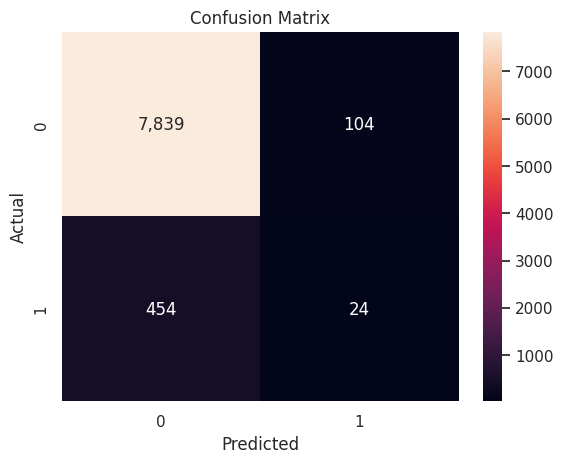

y - 顧客是否已認購定期存款

*   有認購定期存款資料總共有478筆，其中24筆被成功辨識出來，454筆沒有被辨識出來。
*   沒有認購的資料總共有7943筆，其中有104筆資料沒認購被預測為有認購，剩下的7839筆預測皆正確。

模型在Training Set有Overfitting過擬和的問題產生，導致模型在測試上的表現如上圖所見，非常糟糕，之後可針對處理標籤類別不平衡的問題或是經由正規化等方式來改善。


# KNN Evaluate

In [ ]:
evaluate_model_performance(knnclf_model, X_train, X_test, y_train, y_test)

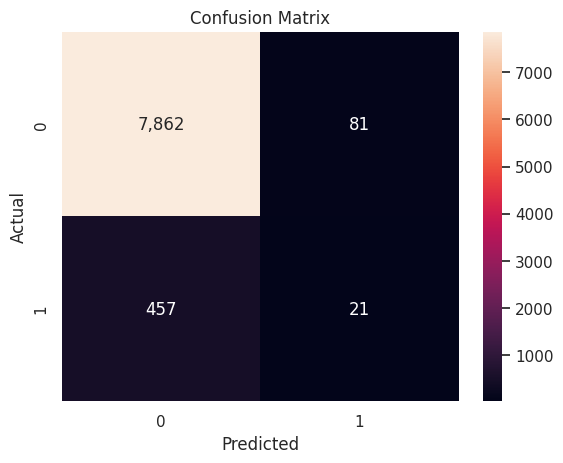

y - 顧客是否已認購定期存款

*   有認購定期存款資料總共有478筆，其中21筆被成功辨識出來，457筆沒有被辨識出來。
*   沒有認購的資料總共有7943筆，其中有81筆資料沒認購被預測為有認購，剩下的7862筆預測皆正確。

模型在Training Set預測類別1的表現不佳,導致在Testing Set預測類別1的表現非常糟糕，之後應先針對標籤類別不平衡的問題來做處理(hw_DT model做過了)。
